# Comparing Different Image Segmentation Techniques
This notebook examines various segmentatoin techniques using the Oxford IIIT Pet datatset. The dataset contains images of various pets and their pixel level foreground-background segmentation masks. These segmentation masks will be used as the 'ground truth' data.  
## Import Packages

> Add blockquote



In [1]:
#import os # Directory navigation
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Segmentation & Metrics
from sklearn.cluster import KMeans
from skimage import segmentation, color, filters, feature, morphology, measure
from scipy import ndimage as ndi
from sklearn.metrics import jaccard_score
import time

# Dataset
import tensorflow_datasets as tfds
import tensorflow as tf


## Helper functions

In [2]:
# Function to help normalize
def normalize(input_image, input_mask):
  # normalize images to values between [0, 1]
  input_image = tf.cast(input_image, tf.float32) / 255.0

  # Subtract 1 from labels, for ease of access
  input_mask -= 1

  # return normalized images and mask
  return input_image, input_mask

# Function to load, resize, and normalize images and corresponding masks
def load_pet_dataset():
  # Create TF data loader for Oxford IIIT Pet dataset
  ds  = tfds.load('oxford_iiit_pet', split='train', with_info=False) # Create TF data loader for Oxford IIIT Pet dataset

  #Create palceholders for images and their corresponding masks
  images, masks = [], []

  # Load first 5 images
  for example in ds.take(5):
    # Resize images & use nearest neighbors to help resize mask
    img = tf.image.resize(example['image'], (128, 128))
    mask = tf.image.resize(example['segmentation_mask'], (128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # normalize images to values between [0, 1]
    img, mask = normalize(img, mask)

    # Append images and masks to place holdeers
    images.append(img)
    masks.append(mask)

  # Return images and masks after processing all 5 images
  return np.array(images), np.array(masks) # Moved return statement outside the loop

# Function to visualize various masks and their Dice values, for easy comparison
def visualize_comparison(image, mask, predictions, titles, times, dices):
    n = len(predictions)
    fig, axs = plt.subplots(2, n + 2, figsize=(4 * (n + 2), 8))

  # Plot Original Image
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Original")
    axs[0, 0].axis('off')
  # Plot Ground Truth
    mask_vis = np.where(mask == 2, 0, mask)
    axs[0, 1].imshow(mask_vis, cmap='gray')
    axs[0, 1].set_title("Ground Truth")
    axs[0, 1].axis('off')

  # Loop to add the other segmentation methods to the plot
    for i in range(n):
        axs[0, i + 2].imshow(predictions[i], cmap='gray') # Show mask
        axs[0, i + 2].set_title(titles[i]) # Set title
        axs[0, i + 2].axis('off')

        axs[1, i + 2].text(0.5, 0.5, f"Dice: {dices[i]:.4f}\nTime: {times[i]:.2f}s", ha='center', va='center', fontsize=12) # Add metric details
        axs[1, i + 2].axis('off')

    axs[1, 0].axis('off')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()


## Functions for Creating Segmentations and Metrics

In [3]:
# Dice Coefficient Calculation
def compute_dice_coefficient(pred, ground_truth):
    # Ensure ground_truth and pred have the same number of dimensions
    if ground_truth.ndim == 3 and pred.ndim == 2:
        ground_truth = ground_truth.squeeze(-1) # Remove the last dimension from ground_truth if it's 3D
    # Grab ground truth segmentation mask
    mask = ground_truth != 2

    # Check for matching pixels between masks
    pred_bin = (pred > 0).astype(np.uint8)[mask]
    true_bin = (ground_truth == 1).astype(np.uint8)[mask]

    # Calculate intersection
    intersection = np.sum(pred_bin * true_bin)

    # Return Dice Coefficent
    return (2. * intersection) / (np.sum(pred_bin) + np.sum(true_bin) + 1e-8)


# K Means Segmentation
def segment_kmeans(image, k=3):
    # Grab and reshape dimensions
    h, w, c = image.shape
    pixels = image.reshape((-1, 3))

    # Calculate k-mean
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pixels)

    # Grab and return Mask
    labels = kmeans.labels_.reshape(h, w)
    return labels

# Canny Edge Detection
def segment_canny(image):
    # Convert to grayscale
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Calculate Canny Edges
    edges = cv2.Canny(gray, 100, 200)

    # Return Canny edges
    return edges

# Adaptive Mask
def segment_adaptive(image):
    # Convert to grayscale
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    # Set Parameters
    block_size = 35
    # Calculate adaptive threshold
    adaptive_thresh = filters.threshold_local(gray, block_size, offset=10)

    # Return adaptive mask
    return (gray > adaptive_thresh).astype(np.uint8) * 255

# Region Growing Segmentation
def segment_region_growing(image, seed_point=(64, 64), threshold=0.2):
    # Convert to grayscale
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    # Set parameters, seed points
    seed_val = gray[seed_point[1], seed_point[0]]

    # Calculate mask
    mask = np.zeros_like(gray, dtype=bool)
    mask[np.abs(gray - seed_val) < (threshold * 255)] = True

    # Return Mask
    return mask.astype(np.uint8) * 255


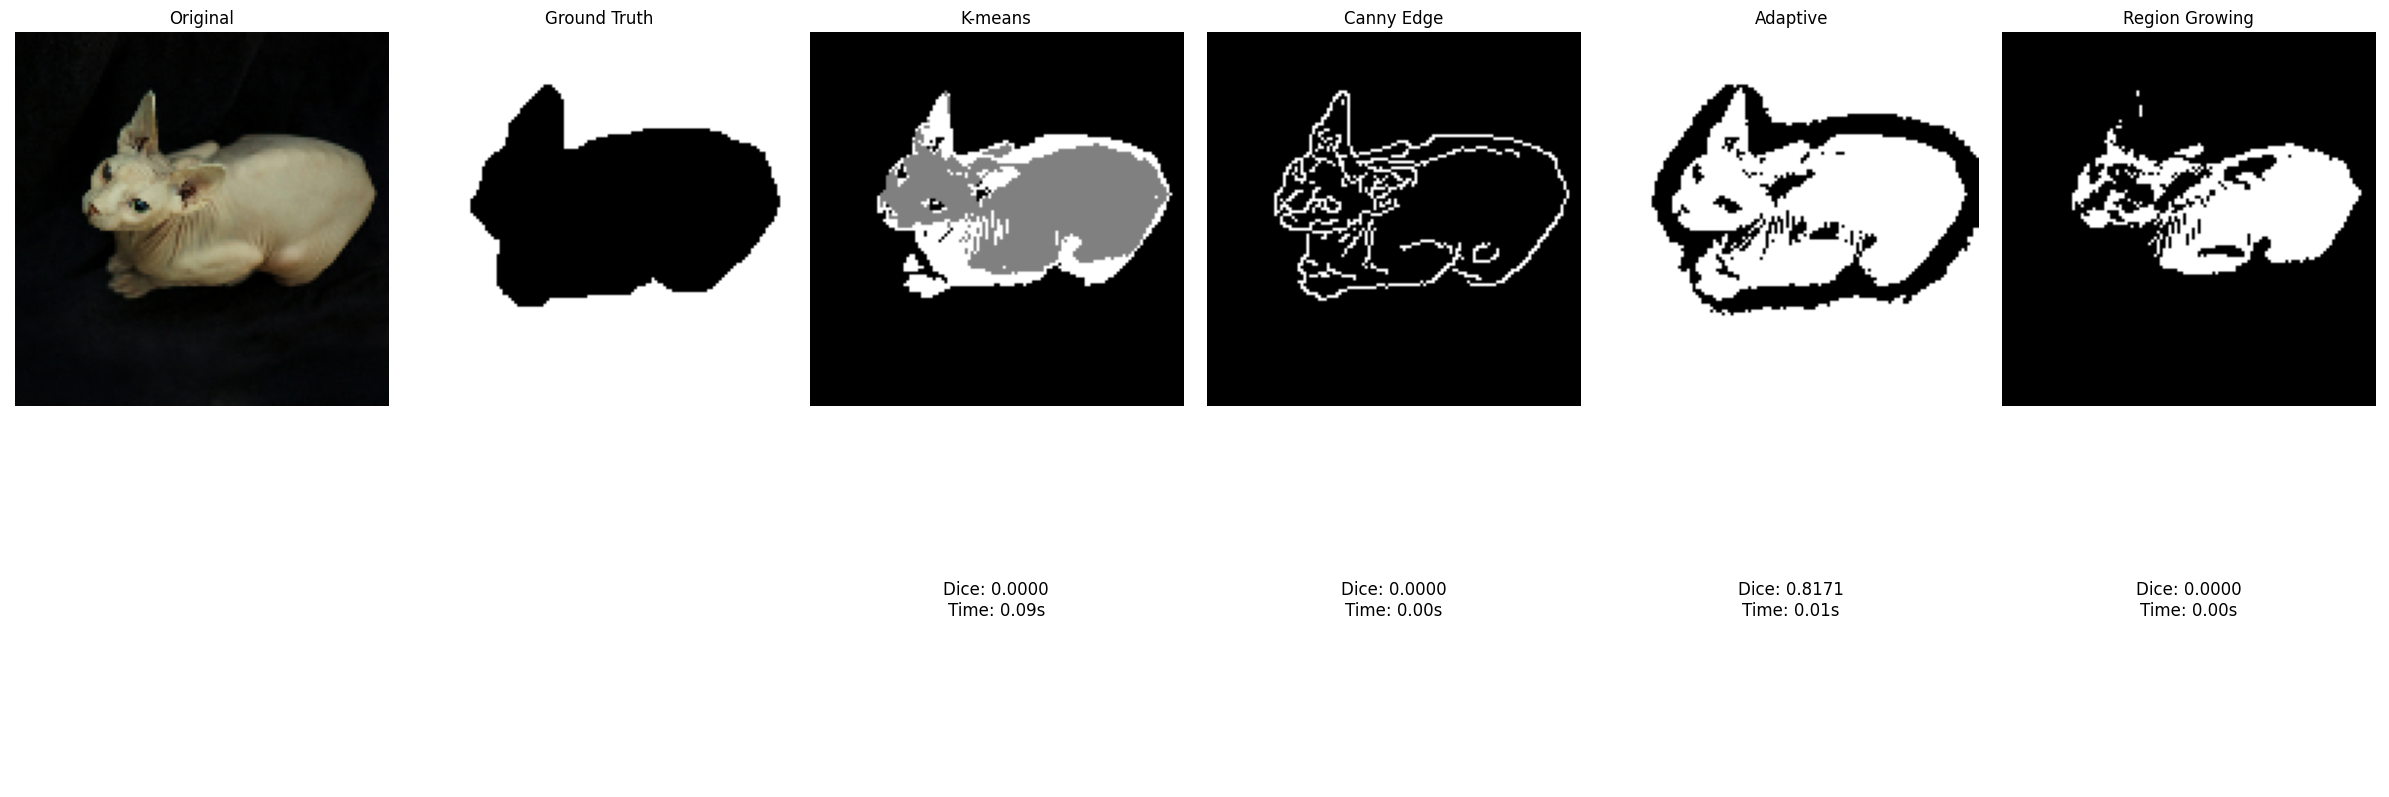

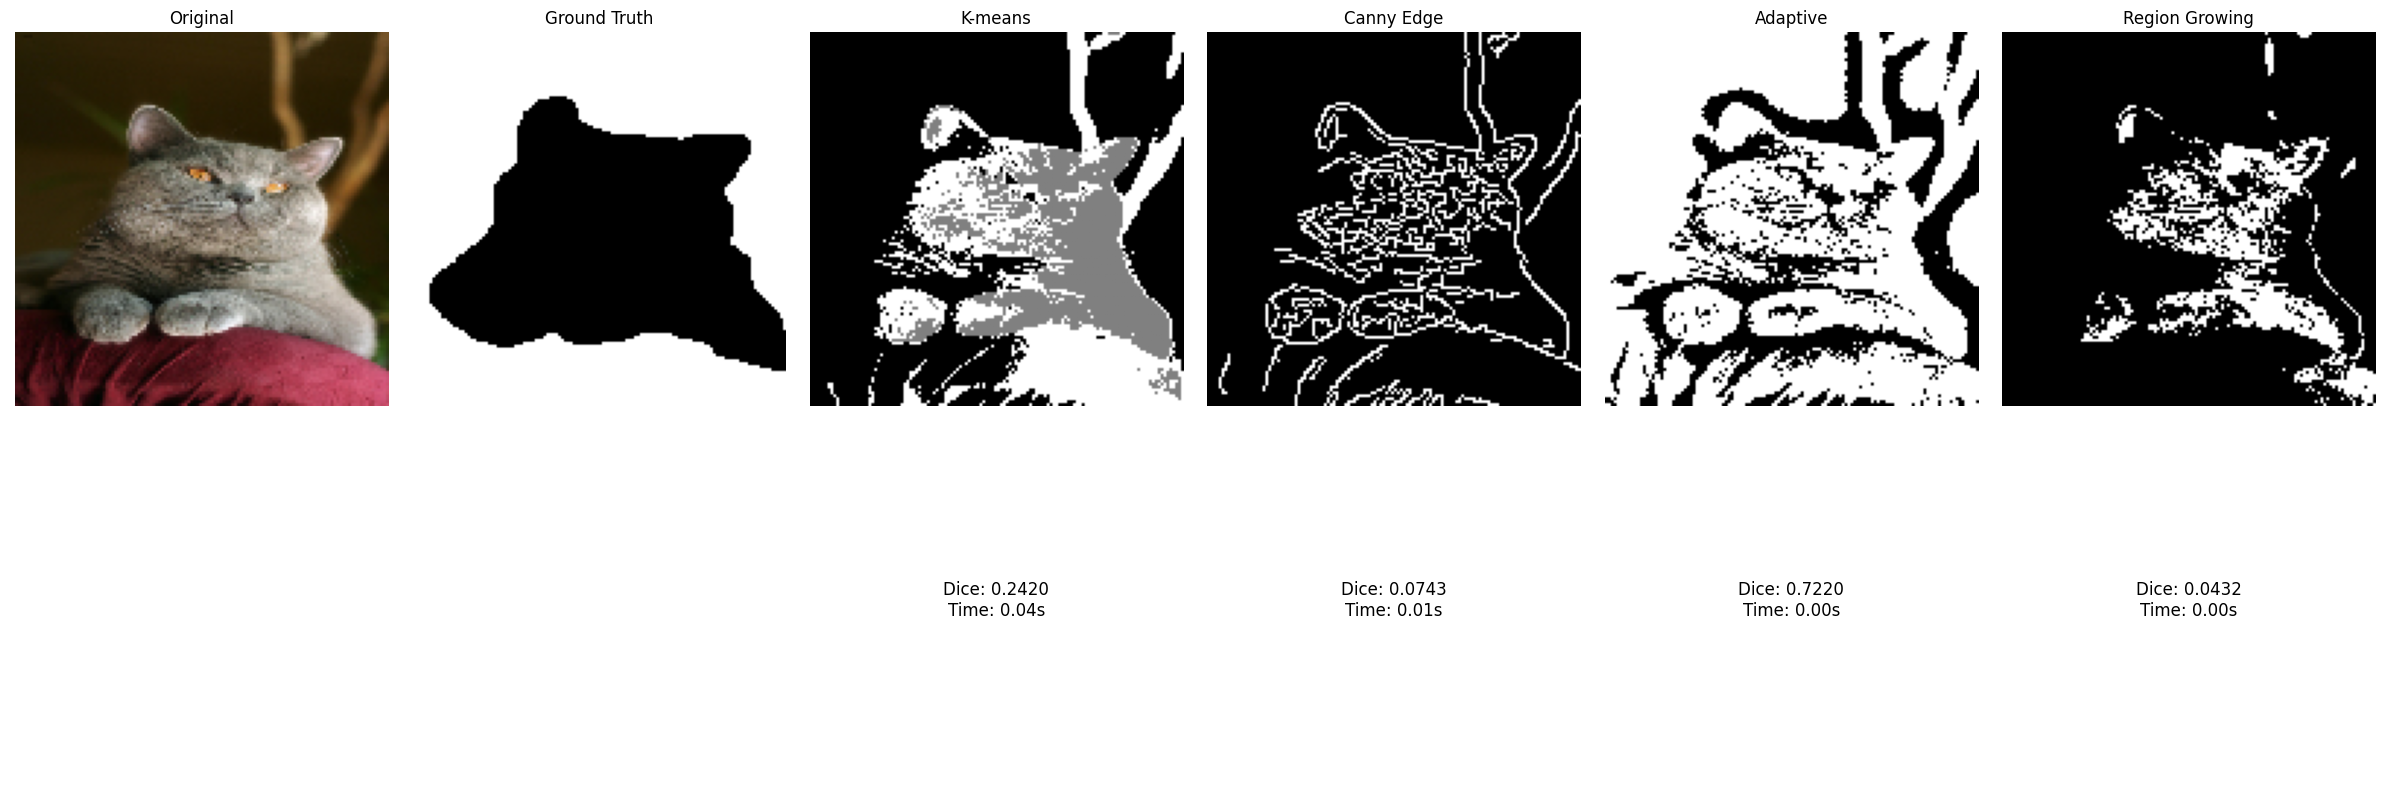

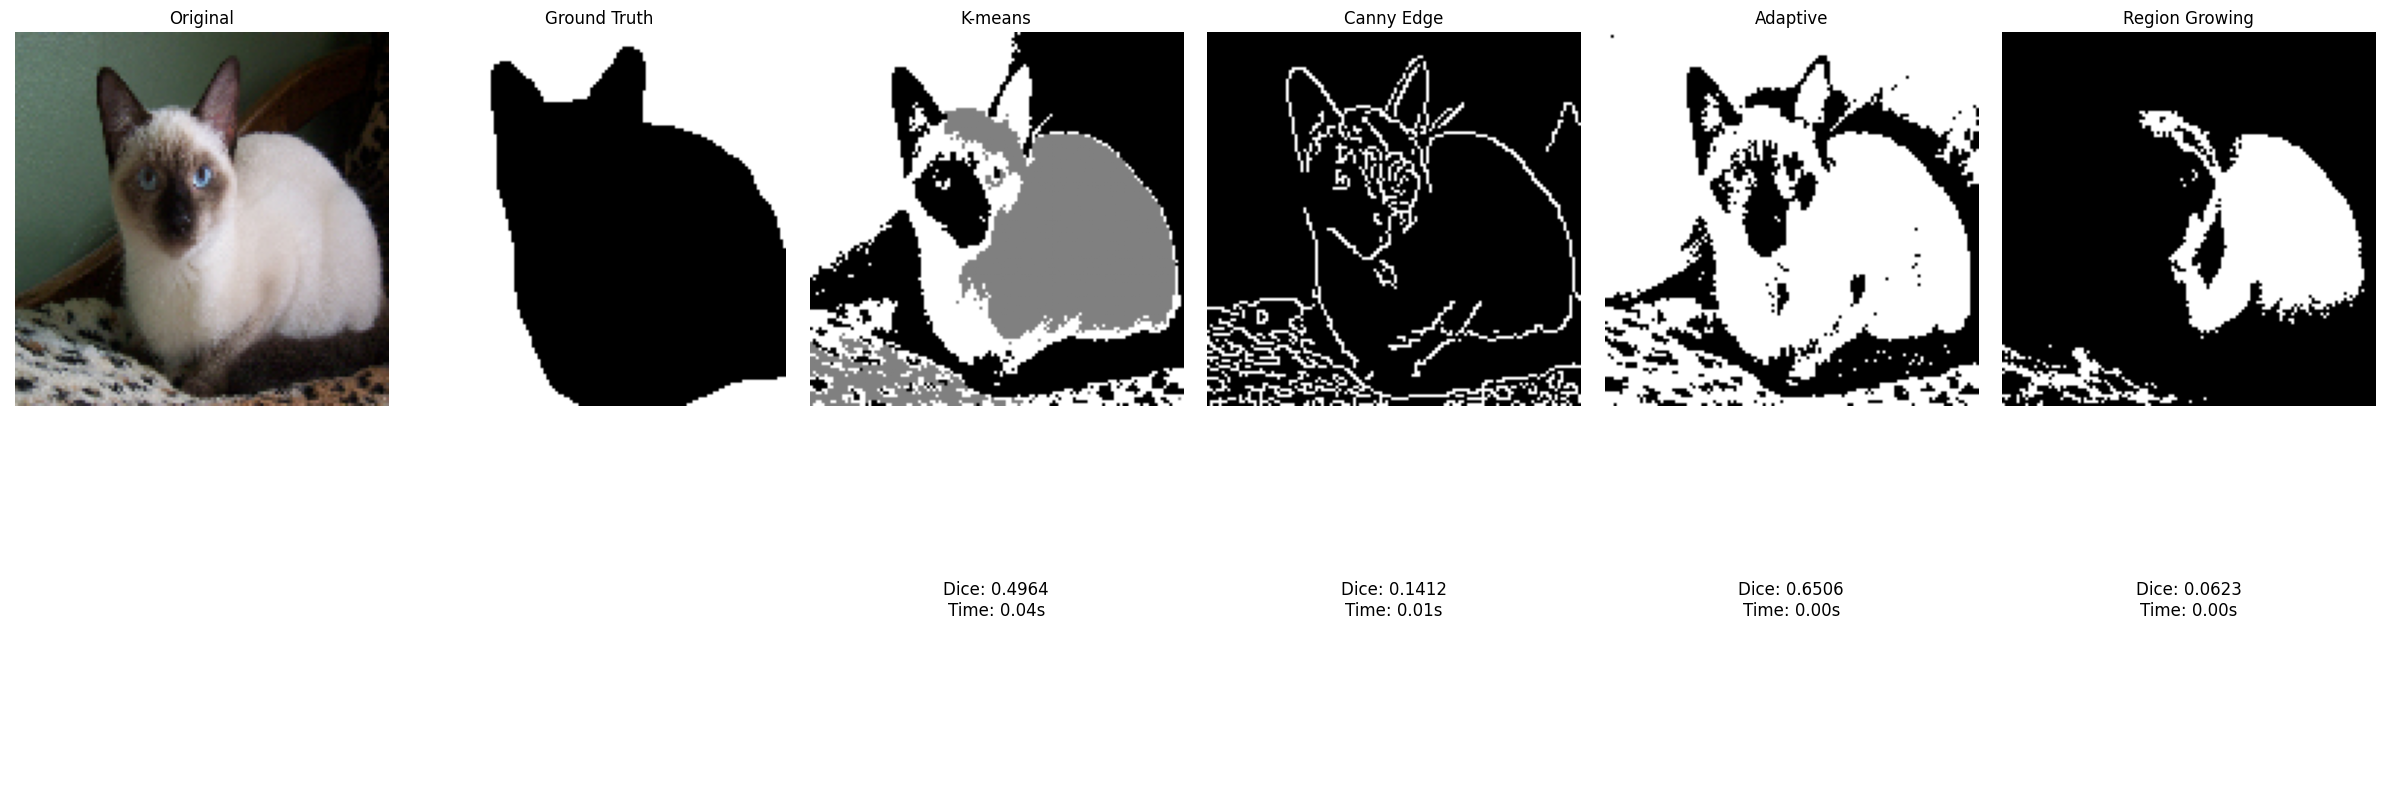

In [4]:
# Load 5 images and masks
imgs, masks = load_pet_dataset()

# Predetermined image indices
img_idx = [0, 2, 3]

# Create segmentation masks for 3 images
for idx in range(3):
    # Grab image and corresponding 'ground-truth' mask
    sample_img = imgs[img_idx[idx]]
    sample_mask = masks[img_idx[idx]]

    # Set titles for graphs
    titles = ["K-means", "Canny Edge", "Adaptive", "Region Growing"]
    # Create placeholders
    segmentations, times, dices = [], [], []

    # Loop through segmentation functions, running each function of the image and mask
    for seg_func in [segment_kmeans, segment_canny, segment_adaptive, segment_region_growing]:
        # Start timer for metrics
        start = time.time()

        # Run function
        seg_output = seg_func(sample_img)

        # End timer
        end = time.time()

        # Append calculated values
        segmentations.append(seg_output)
        times.append(end - start)
        dices.append(compute_dice_coefficient(seg_output, sample_mask))
    visualize_comparison(
        sample_img, sample_mask,
        segmentations,
        titles,
        times,
        dices
    )


## Discussion:

Edge detection can strongly influence segmentation performance. If high quality and accurate edges are provided, Edge Detection can significantly improve the performance of segmentation processes. On the other hand, if poorly defined edges are provided, this will negatively effect the segmentation results.

In the examples above, the Dice Coefficent is quite low (0 in some cases). This doesn't mean that the generated mask is poor, it just doesn't align the  binary mask provided by Oxford IIIT.

## Resources used:

*   [Image segmentation - TensorFlow Tutorial](https://www.tensorflow.org/tutorials/images/segmentation#define_the_model)
*   [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)